In [9]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('../../data/df_6H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (35064, 39)

Number of unique patients: 5844

SepsisLabel class counts:
 SepsisLabel
1.0    17532
0.0    17532
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2922
1.0    2922
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [3]:
# split
train_df, test_df = split_train_test_data_v2(data) 

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

functions_and_imports.ipynb:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",
functions_and_imports.ipynb:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "def extract_sequences_and_labels(df, patient_col, time_col, feature_cols, label_col, sequence_length):\n",


In [4]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((4675, 6, 35), (4675,), (1169, 6, 35), (1169,))

In [83]:
from tensorflow.keras.layers import Conv1D, Flatten
def build_and_train_custom_tcn_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=256):
    """
    Construit et entraîne un modèle TCN personnalisé en utilisant Conv1D pour la prédiction.
    
    Args:
    - X_train: Séquences d'entraînement.
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation.
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle TCN personnalisé entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        Conv1D(128, kernel_size=3, dilation_rate=1, activation='relu',padding='same', input_shape=input_shape),
        Dropout(0.3),
        Conv1D(32, kernel_size=3, dilation_rate=2, activation='relu', padding='same'),
        Dropout(0.3),
        Conv1D(16, kernel_size=3, dilation_rate=4, activation='relu', padding='same'),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [84]:
input_shape = (6, 35)
model_tcn, history_tcn = build_and_train_custom_tcn_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)


Epoch 1/300


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4965 - loss: 0.6977 - val_accuracy: 0.5295 - val_loss: 0.6907
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5029 - loss: 0.6934 - val_accuracy: 0.5287 - val_loss: 0.6893
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5291 - loss: 0.6925 - val_accuracy: 0.5920 - val_loss: 0.6867
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5297 - loss: 0.6892 - val_accuracy: 0.5877 - val_loss: 0.6823
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5373 - loss: 0.6869 - val_accuracy: 0.5979 - val_loss: 0.6782
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5569 - loss: 0.6849 - val_accuracy: 0.6099 - val_loss: 0.6750
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5735 - loss: 0.6826 - val_accuracy: 0.6125 - val_loss: 0.6699
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5843 - loss: 0.6784 - val_accuracy: 0.6185 - val_l

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8517 - loss: 0.3604 - val_accuracy: 0.8820 - val_loss: 0.3114
Epoch 52/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8542 - loss: 0.3562 - val_accuracy: 0.8811 - val_loss: 0.3064
Epoch 53/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8400 - loss: 0.3668 - val_accuracy: 0.8837 - val_loss: 0.3042
Epoch 54/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8445 - loss: 0.3628 - val_accuracy: 0.8845 - val_loss: 0.3027
Epoch 55/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8541 - loss: 0.3509 - val_accuracy: 0.8785 - val_loss: 0.3006
Epoch 56/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8569 - loss: 0.3411 - val_accuracy: 0.8802 - val_loss: 0.3032
Epoch 57/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8532 - loss: 0.3507 - val_accuracy: 0.8802 - val_loss: 0.3004
Epoch 58/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8582 - loss: 0.3456 - val_accuracy: 0.8845 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8817 - loss: 0.2855 - val_accuracy: 0.8948 - val_loss: 0.2648
Epoch 102/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8691 - loss: 0.3070 - val_accuracy: 0.8999 - val_loss: 0.2646
Epoch 103/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8721 - loss: 0.2964 - val_accuracy: 0.8931 - val_loss: 0.2656
Epoch 104/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8732 - loss: 0.3039 - val_accuracy: 0.8965 - val_loss: 0.2632
Epoch 105/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8894 - loss: 0.2868 - val_accuracy: 0.8982 - val_loss: 0.2708
Epoch 106/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8852 - loss: 0.2870 - val_accuracy: 0.9008 - val_loss: 0.2630
Epoch 107/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8805 - loss: 0.2905 - val_accuracy: 0.8965 - val_loss: 0.2642
Epoch 108/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8832 - loss: 0.2810 - val_accuracy: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9004 - loss: 0.2497 - val_accuracy: 0.9042 - val_loss: 0.2481
Epoch 152/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8857 - loss: 0.2748 - val_accuracy: 0.9059 - val_loss: 0.2458
Epoch 153/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8931 - loss: 0.2546 - val_accuracy: 0.9025 - val_loss: 0.2518
Epoch 154/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8924 - loss: 0.2535 - val_accuracy: 0.9068 - val_loss: 0.2470
Epoch 155/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8968 - loss: 0.2679 - val_accuracy: 0.9059 - val_loss: 0.2490
Epoch 156/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9033 - loss: 0.2492 - val_accuracy: 0.9076 - val_loss: 0.2458
Epoch 157/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9035 - loss: 0.2423 - val_accuracy: 0.9042 - val_loss: 0.2467
Epoch 158/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9022 - loss: 0.2426 - val_accuracy: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9113 - loss: 0.2262 - val_accuracy: 0.9110 - val_loss: 0.2442
Epoch 202/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9077 - loss: 0.2256 - val_accuracy: 0.9102 - val_loss: 0.2436
Epoch 203/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9105 - loss: 0.2284 - val_accuracy: 0.9093 - val_loss: 0.2412
Epoch 204/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9067 - loss: 0.2317 - val_accuracy: 0.9110 - val_loss: 0.2421
Epoch 205/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9128 - loss: 0.2232 - val_accuracy: 0.9050 - val_loss: 0.2443
Epoch 206/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9037 - loss: 0.2321 - val_accuracy: 0.9102 - val_loss: 0.2415
Epoch 207/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9132 - loss: 0.2234 - val_accuracy: 0.9102 - val_loss: 0.2418
Epoch 208/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9116 - loss: 0.2307 - val_accuracy: 

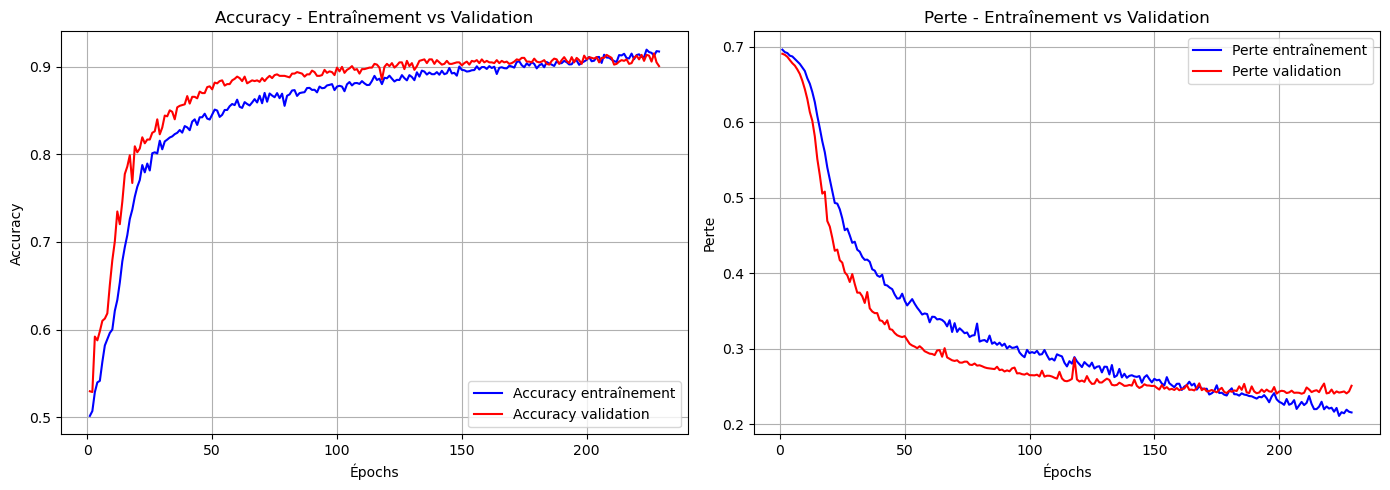

In [85]:
plot_training_history(history_tcn)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.9119
Precision: 0.9146
Recall: 0.9130
F1-Score: 0.9138
AUROC: 0.9638


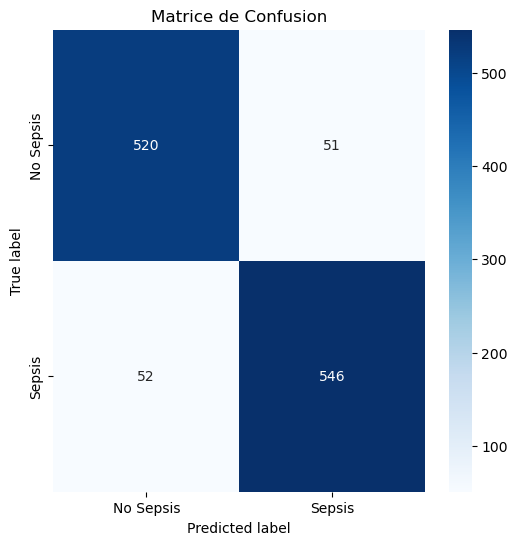

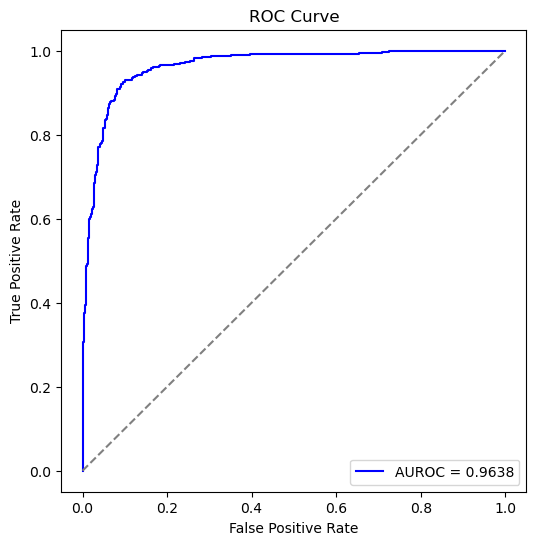

In [86]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_tcn, normalize_sequences_test, labels_test)